<a href="https://colab.research.google.com/github/yiruchen1993/nvidia_gtc_dli_rapids_2020/blob/section_notebooks%2Fdata_manipulation/1_07_dask_cudf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dask cuDF 簡介

[Dask](https://dask.org/) cuDF 可用來將資料架構作業分配給多個 GPU。在此學習筆記中，我們將介紹關鍵的 Dask 概念，瞭解如何設定 Dask 叢集以運用多 GPU，以及如何在分散式 Dask 資料架構上執行簡單的資料架構作業。

## 目標

完成此學習筆記後，你將能夠:

- 建立 Dask GPU 叢集
- 在多個 GPU 上建立並執行 Dask cuDF DataFrame 運算圖表

# Dask 簡介

[Dask](https://dask.org/) 是適用於平行運算的 Python 函式庫。在 Dask 程式設計中，我們會建立運算圖表，定義我們**想要**執行的程式碼，然後將這些運算圖表放到 Dask 排程器中，同時以延遲和積極方式評估這些圖表。

除了使用多 GPU 核心或執行緒以同時執行運算圖表外，我們也可以設定 Dask 排程器，在多 CPU 或多 GPU (如我們即將於本實作坊中執行的操作) 上執行運算圖表。因此，Dask 程式設計有助於大於單一運算資源記憶體的資料集作業。

由於 Dask 運算圖表可以包含任意的 Python 程式碼，這些圖表所提供的[控制程度和彈性超越其他許多系統](https://docs.dask.org/en/latest/spark.html)，能夠在大型資料集上作業。不過在本實作坊中，我們將把重點放在 Dask DataFrame 上，這是其中一種其作業與方法會以原生方式運用 Dask 平行排程的資料架構:

- Dask DataFrame 與 Pandas DataFrame 非常相似
- Dask Array 與 NumPy ndarray 非常相似
- Dask Bag 是可以複製，且能夠容納異質性資料的集合

我們將特別使用 Dask-cuDF 資料架構，其結合 Dask 介面以及 cuDF 的 GPU 效能，能在多 GPU 上進行分散式資料架構作業。我們現在會將焦點轉向在此環境中運用所有 4 個 NVIDIA V100 GPU，並處理超過單一 16GB GPU 記憶體可容納的 18GB 英國資料集。

## 設定 Dask 排程器

我們將從設定 Dask 排程器開始，將作業分散至 4 個可用的 GPU 上。為了做到這點，我們需要啟動一個 `LocalCUDACluster` 執行個體，使用我們的主機 IP，再具現化可以與叢集通訊的用戶端。

### 獲得本機 IP 位址

In [ ]:
import subprocess # we will use this to obtain our local IP using the following command
cmd = "hostname --all-ip-addresses"

process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
IPADDR = str(output.decode()).split()[0]
print(IPADDR)

172.18.0.4


### 啟動 `LocalCUDACluster`

`dask_cuda` 提供 Dask 與 CUDA (cuDF 中的「cu」) 互動所需的公用程式。

In [ ]:
from dask_cuda import LocalCUDACluster
cluster = LocalCUDACluster(ip=IPADDR)

### 具現化用戶端連線

`dask.distributed` 函式庫提供分散式功能，包括與我們剛剛建立的 CUDA 叢集連線。`progress` 匯入則提供我們可於下方使用的實用進度條。

In [ ]:
from dask.distributed import Client, progress

client = Client(cluster)
client

Client Scheduler: tcp://172.18.0.4:35881 Dashboard: http://172.18.0.4:8787/status,Cluster Workers: 4 Cores: 4 Memory: 473.42 GB


### Dask 儀表板

如你所見，`client` 執行個體提供我們 CUDA 叢集 (運用 4 個 GPU) 的相關資訊，以及用戶端連線的資訊。Dask 內建非常實用的儀表板，此儀表板使用連接埠 `8787` 執行。現在於 `<YOUR_IP_ADDRESS>:8787` 開啟新的瀏覽器分頁，如 `ec#-#-#-#-#.compute-1.amazonaws.com:8787`，這樣一來，應該就能開啟目前閒置的 Dask 儀表板。

## 使用 Dask cuDF 讀取資料

透過 `dask_cudf`，我們可以使用多種檔案格式 (包含從多個檔案以及直接從 S3 等雲端儲存空間)、cuDF 資料架構、Pandas 資料架構，甚至 Vanilla CPU Dask 資料架構來建立資料架構。此處我們將從本機 csv 檔案 `pop5x_1-07.csv` 建立 Dask cuDF 資料架構，其功能與你已經使用的 `pop.csv` 檔案類似，惟規模提高了 5 倍 (18GB)，代表將近 3 億人口，幾乎等同於全美人口數量。

In [ ]:
# get the file size of `pop5x_1-07.csv` in GB
!ls -sh data/pop5x_1-07.csv

18G data/pop5x_1-07.csv


在設定叢集後，我們會匯入 dask_cudf (必要時還有其他 RAPIDS 元件)，以確保在其建立的 CUDA 情境中正確建立叢集。

In [ ]:
import dask_cudf

In [ ]:
ddf = dask_cudf.read_csv('./data/pop5x_1-07.csv', dtype=['float32', 'str', 'str', 'float32', 'float32', 'str'])

In [ ]:
ddf.dtypes

age       float32
sex        object
county     object
lat       float32
long      float32
name       object
dtype: object

In [ ]:
ddf.shape # delay function 還沒執行

(Delayed('int-e9d5c4c2-a5d2-4ab3-8f86-0c99348ff226'), 6)

如上所述，使用 Dask 程式設計時，我們會建立自己**最終希望**執行的運算圖表。我們已經觀察到這個情況正在發生: 在呼叫 `dask_cudf.read_csv` 時，我們已表示**最終希望**讀取 `pop5x_1-07.csv` 的完整內容。然而，除非我們明確表示，否則 Dask 不會要求排程器執行此工作。

執行下列儲存格，觀察 4 個 GPU 個別記憶體的使用狀況，可發現 GPU 記憶體使用量遠不足以完整表示已讀入記憶體的 18GB 檔案:

In [ ]:
!nvidia-smi

Wed Oct  7 06:12:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 000091FC:00:00.0 Off |                    0 |
| N/A   30C    P0    34W / 250W |    932MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 0000A964:00:00.0 Off |                    0 |
| N/A   31C    P0    36W / 250W |    317MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## 視覺化運算圖表

尚未執行的運算圖表提供了 `.visualize` 方法，讓我們能夠在使用這類 Jupyter 環境時顯示運算圖表，包含 Dask 打算分散工作的方式。因此，我們可以透過執行下列儲存格，將 Dask 分散 `read_csv` 作業的方式視覺化。

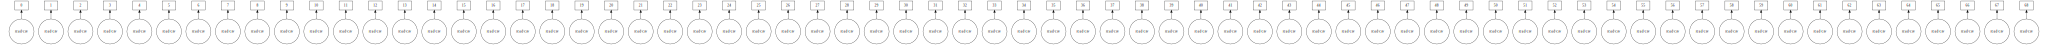

In [ ]:
ddf.visualize(format='svg') # This visualization is very large, and using `format='svg'` will make it easier to view.

如你所見，我們指示 Dask 實際執行作業時，Dask 能夠同時在 4 個 GPU 中以 69 個平行分割區同時處理工作。我們可以透過 `npartitions` 屬性查看確切的分割區數量:

In [ ]:
ddf.npartitions

69

## 延伸運算圖表

先使用任意作業建立運算圖表再執行作業是 Dask 的核心概念。讓我們在現有的運算圖表中新增部分作業，並再次將其視覺化。

執行下一個儲存格後，雖然我們需要捲動一下，才能清楚瞭解儲存格內容 (分散式資料分析的挑戰！)，但你可以發現為 `read_csv` 建立的圖表現已繼續執行。此圖表會選擇所有分割區中的 `age` 欄 (視覺化為 `getitem`) 且最終會執行 `.mean()` 扣除 (視覺化為 `series-sum-chunk`、`series-sum-agg`、`count-chunk`、`sum-agg` 與 `true-div`)。

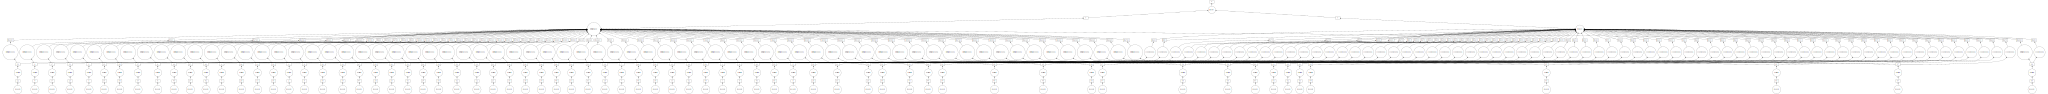

In [ ]:
mean_age = ddf['age'].mean()
mean_age.visualize(format='svg')

## 使用運算圖表運算

我們可透過幾種方式，向 Dask 表示想要執行已建立運算圖表中所述的運算。我們首先示範的是 `.compute` 方法，此方法會將運算結果輸出當成 GPU 記憶體的一項物件傳回，不再分散到各 GPU。

(**注意**: 此值實際上是 [*Future*](https://docs.python.org/3/library/concurrent.futures.html)，不需等待評估結束，即可馬上於程式碼中使用。雖然在許多狀況下非常實用，但在此實作坊中，我們不需要對產生的 Future 執行任何複雜動作，只要等待評估，以便視覺化其值即可)。

執行下列儲存格，將已建立的運算圖表傳送至要在 4 個 GPU 上同時執行的 Dask 排程器。如果你先前已在其他分頁開啟 Dask 儀表板，可以在完成作業的過程中檢視儀表板。由於我們的圖表包含讀取整個 18GB 資料集 (如同我們將 `read_csv` 新增至呼叫圖表時所宣告)，因此作業會花上一點時間。仔細觀察儀表板，你會發現在資料讀入記憶體的同時，Dask 就會開始進行後續的 `mean` 計算。

In [ ]:
mean_age.compute()

40.124193580104645

### 在叢集中保留資料

如你所見，在先前作業中，完整的 18GB csv 檔案都讀入了 GPU 記憶體，但在完成運算圖表後，並未在記憶體中保留這些資料:

In [ ]:
!nvidia-smi

Wed Oct  7 06:17:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 000091FC:00:00.0 Off |                    0 |
| N/A   30C    P0    34W / 250W |   1240MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 0000A964:00:00.0 Off |                    0 |
| N/A   31C    P0    36W / 250W |    625MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

我們將運用典型的 Dask 工作流程，把想運用的資料保留在叢集中，並利用保留的資料加速作業。我們可以透過 `.persist` 方法實現此目標。從 [Dask 文件](https://distributed.dask.org/en/latest/manage-computation.html#client-persist):

> `.persist` 方法會將 Dask 集合背後的工作圖表提交給排程器，為所有最重要工作取得 Future (例如: 在 Dask[*-cudf*] DataFrame 中，各 Pandas [* 或 cuDF*] DataFrame 皆有一個 Future)。接著，會傳回指向這些 Future 的集合副本，而非先前的圖表。此新集合在語意上相同，但現在會指向主動執行的資料，而非消極圖表。

這時我們會將 `ddf` 保留在叢集中，使其留在 GPU 記憶體內，讓我們可以快速執行作業:

In [ ]:
ddf = ddf.persist()

如你所見，透過執行 `nvidia-smi` (在 `persist` 結束後)，各 GPU 的記憶體中現在皆具有部分分散式資料架構，可用空間也從原本磁碟上的 18GB，擴充到記憶體中約 32GB:

In [ ]:
!nvidia-smi

Wed Oct  7 06:18:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 000091FC:00:00.0 Off |                    0 |
| N/A   30C    P0    40W / 250W |   3096MiB / 16160MiB |     53%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 0000A964:00:00.0 Off |                    0 |
| N/A   31C    P0    43W / 250W |   2937MiB / 16160MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

現在執行 `ddf.visualize`，會顯示我們的工作圖表中不再有作業，只有已準備好讓我們執行作業的資料分割區:

In [ ]:
ddf.visualize(format='svg')

此資料的運算作業現在會更加快速:

In [ ]:
ddf['age'].mean().compute()

40.1241934569854

## 使用 Dask cuDF 啟動資料探索

Dask 的優點在於，即便處理的是分散式的龐大資料架構，仍與處理較小的記憶體內資料集相似。

In [ ]:
ddf.head() # As a convenience, no need to `.compute` the `head()` method

,age,sex,county,lat,long,name
0,0.0,m,Darlington,54.549641,-1.493884,HARRISON
1,0.0,m,Darlington,54.523945,-1.401142,LAKSH
2,0.0,m,Darlington,54.561127,-1.690068,MUHAMMAD
3,0.0,m,Darlington,54.542988,-1.543216,GRAYSON
4,0.0,m,Darlington,54.532101,-1.569116,FINLAY


In [ ]:
ddf.count().compute()

age       292399470
sex       292399470
county    292399470
lat       292399470
long      292399470
name      292399470
dtype: int64

In [ ]:
ddf.dtypes

age       float32
sex        object
county     object
lat       float32
long      float32
name       object
dtype: object

## 練習: 使用 Dask 找出桑德蘭以北的郡

以下我們將要求你重新檢視先前的一項練習，但這次要使用分散式資料集。希望你能清楚瞭解單一 GPU 資料架構與 Dask 分散式資料架構的程式碼很相似。

找出桑德蘭郡最北邊居民的緯度 (`lat` 值最高的人)，接著判斷哪些郡的居民位於他的北方。使用 cuDF `Series` 的 `unique` 方法來刪除結果中重複的項目。

#### 解決方案

In [ ]:
%load solutions/counties_north_of_sunderland_ddf

## 下一步

看完 Dask cuDF 簡介後，你現在將繼續前往下一份學習筆記，使用 Dask 進行更進階的資料轉換、重新檢視網格座標轉換工具函數，但這次將運用在大小是先前 5 倍的 18GB 英國人口資料集上。

<br>
<div align="center"><h2>請重新啟動核心</h2></div>